In [ ]:
!pip -q install pyspark==3.5.0 delta-spark==3.1.0



In [10]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql import functions as F, types as T

builder = (
    SparkSession.builder.appName("DeltaRideHailing")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()


In [5]:
# Define schema
trip_schema = T.StructType([
    T.StructField("trip_id",      T.IntegerType()),
    T.StructField("rider_id",     T.StringType()),
    T.StructField("driver_id",    T.StringType()),
    T.StructField("city",         T.StringType()),
    T.StructField("distance_km",  T.DoubleType()),
    T.StructField("fare",         T.DoubleType()),
    T.StructField("tip",          T.DoubleType()),
    T.StructField("ts",           T.TimestampType())
])

driver_schema = T.StructType([
    T.StructField("driver_id",  T.StringType()),
    T.StructField("driver_name",T.StringType()),
    T.StructField("rating",     T.DoubleType()),
    T.StructField("vehicle",    T.StringType())
])

from datetime import datetime

# Create rows
trips_rows = [
    (1001,"R001","D010","Bengaluru", 12.4, 320.0, 20.0,  datetime.strptime("2025-08-08 08:05:00", "%Y-%m-%d %H:%M:%S")),
    (1002,"R002","D011","Hyderabad",  6.2, 150.0, 10.0,  datetime.strptime("2025-08-08 08:15:00", "%Y-%m-%d %H:%M:%S")),
    (1003,"R003","D012","Pune",       3.5,  90.0,  0.0,  datetime.strptime("2025-08-08 08:20:00", "%Y-%m-%d %H:%M:%S")),
    (1004,"R001","D010","Bengaluru", 18.9, 480.0, 25.0,  datetime.strptime("2025-08-08 08:45:00", "%Y-%m-%d %H:%M:%S")),
    (1005,"R004","D013","Chennai",   10.0, 260.0, 15.0,  datetime.strptime("2025-08-08 09:05:00", "%Y-%m-%d %H:%M:%S")),
    (1006,"R005","D012","Pune",       2.2,  70.0,  0.0,  datetime.strptime("2025-08-08 09:10:00", "%Y-%m-%d %H:%M:%S")),
]

drivers_rows = [
    ("D010","Anil",   4.8,"WagonR"),
    ("D011","Sana",   4.6,"i20"),
    ("D012","Rakesh", 4.4,"Swift"),
    ("D013","Meera",  4.9,"Ciaz")
]

trips_df   = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

# Save to Delta
BASE = "/tmp/delta/ride_hailing"
TRIPS_PATH   = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print("Seeded:")
print("  Trips  ->", TRIPS_PATH)
print("  Drivers->", DRIVERS_PATH)

Seeded:
  Trips  -> /tmp/delta/ride_hailing/trips
  Drivers-> /tmp/delta/ride_hailing/drivers


#Managed vs Unmanaged table

In [7]:
#Create a managed Delta table trips_managed by AS SELECT from the Delta path.
spark.sql("DROP TABLE IF EXISTS trips_managed")
spark.sql(f"""
  CREATE TABLE trips_managed
  USING DELTA
  AS SELECT * FROM delta.`{TRIPS_PATH}`
""")
#Create an external (unmanaged) table drivers_ext that points to DRIVERS_PATH .
spark.sql("DROP TABLE IF EXISTS drivers_ext")
spark.sql(f"""
  CREATE TABLE drivers_ext
  USING DELTA
  LOCATION '{DRIVERS_PATH}'
""")
#Verify locations with DESCRIBE DETAIL and explain the difference in your own words.
print("Managed:")
spark.sql("DESCRIBE DETAIL trips_managed").select("location").show(truncate=False)

print("Unmanaged:")
spark.sql("DESCRIBE DETAIL drivers_ext").select("location").show(truncate=False)

Managed:
+-------------------------------------------+
|location                                   |
+-------------------------------------------+
|file:/content/spark-warehouse/trips_managed|
+-------------------------------------------+

Unmanaged:
+------------------------------------+
|location                            |
+------------------------------------+
|file:/tmp/delta/ride_hailing/drivers|
+------------------------------------+



#Read & Explore

In [10]:
#Read both tables, print schemas, and show 10 rows.
trips_df = spark.sql("SELECT * FROM trips_managed")
drivers_df = spark.sql("SELECT * FROM drivers_ext")

trips_df.printSchema()
drivers_df.printSchema()

trips_df.show(10)
drivers_df.show(10)
#Compute a derived column total_amount = fare + tip and show top 5 trips by total_amount .
trips_df.withColumn("total_amount", F.col("fare") + F.col("tip")).orderBy(F.col("total_amount").desc()).show(5)

root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
|   1001|    R001|     D010

#Update (Business Rule)
.

In [11]:
#Increase tip by 5 for trips in Bengaluru where distance_km > 15 .
#Show before/after for affected rows only

spark.sql("SELECT * FROM trips_managed WHERE city='Bengaluru' AND distance_km>15").show()

spark.sql("""
  UPDATE trips_managed
  SET tip = tip + 5
  WHERE city = 'Bengaluru' AND distance_km > 15
""")


spark.sql("SELECT * FROM trips_managed WHERE city='Bengaluru' AND distance_km>15").show()


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



#Delete (Data Quality)

In [12]:
#Delete trips where fare <= 0 or distance_km <= 0 (simulate bad ingest).
spark.sql("""
  DELETE FROM trips_managed
  WHERE fare <= 0 OR distance_km <= 0
""")

print("Remaining rows:", spark.sql("SELECT COUNT(*) FROM trips_managed").collect()[0][0])


Remaining rows: 6


#Merge (Upsert New Batch)
Create a new inline batch with:
one existing trip_id (e.g., 1004) but a corrected fare or tip, and
one new trip (e.g., 1007). Perform a MERGE (match on trip_id ) to update the
existing and insert the new.
Show rows for trip_id IN (1004,1007) to confirm.

In [9]:
!pip install -q pyspark==3.5.0 delta-spark==3.1.0
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
builder = (
    SparkSession.builder.appName("DeltaMergeExample")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()
updates = [
    (1004, "R001", "D010", "Bengaluru", 18.9, 500.0, 30.0, datetime.datetime(2025, 8, 8, 8, 45, 0)),
    (1007, "R006", "D011", "Hyderabad",  7.5, 180.0, 12.0, datetime.datetime(2025, 8, 8, 10, 15, 0))
]
updates_df = spark.createDataFrame(updates, schema=trip_schema)
delta_trips = DeltaTable.forPath(spark, TRIPS_PATH)
delta_trips.alias("t") \
    .merge(updates_df.alias("s"), "t.trip_id = s.trip_id") \
    .whenMatchedUpdateAll() \
    .whenNotMatchedInsertAll() \
    .execute()
spark.read.format("delta").load(TRIPS_PATH) \
    .filter("trip_id IN (1004, 1007)") \
    .show()


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1007|    R006|     D011|Hyderabad|        7.5|180.0|12.0|2025-08-08 10:15:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [2]:
!pip install delta-spark==3.1.0




#Gold View (Join & KPIs)
* Join trips with drivers on driver_id .
* Create a gold view with columns: trip_id, city, driver_name, rating,
distance_km, total_amount, ts .
1. From this gold view:
* Compute city-wise total revenue and average driver rating.
* Compute driver-wise total trips and top 3 drivers by revenue.



In [15]:
gold_view = spark.sql("""
  SELECT t.trip_id, t.city, d.driver_name, d.rating, t.distance_km,
         (t.fare + t.tip) AS total_amount, t.ts
  FROM trips_managed t
  JOIN drivers_ext d ON t.driver_id = d.driver_id
""")
gold_view.createOrReplaceTempView("gold_view")

# City-wise revenue & avg rating
spark.sql("""
  SELECT city, SUM(total_amount) AS revenue, AVG(rating) AS avg_rating
  FROM gold_view
  GROUP BY city
""").show()

# Driver-wise trips & top 3 by revenue
spark.sql("""
  SELECT driver_name, COUNT(*) AS total_trips, SUM(total_amount) AS revenue
  FROM gold_view
  GROUP BY driver_name
  ORDER BY revenue DESC
  LIMIT 3
""").show()


+---------+-------+----------+
|     city|revenue|avg_rating|
+---------+-------+----------+
|  Chennai|  275.0|       4.9|
|     Pune|  160.0|       4.4|
|Bengaluru|  850.0|       4.8|
|Hyderabad|  160.0|       4.6|
+---------+-------+----------+

+-----------+-----------+-------+
|driver_name|total_trips|revenue|
+-----------+-----------+-------+
|       Anil|          2|  850.0|
|      Meera|          1|  275.0|
|     Rakesh|          2|  160.0|
+-----------+-----------+-------+



#Time Travel & History

In [16]:
#Show DESCRIBE HISTORY for the trips table (the one you updated/merged).
#Read the table as of version 0, and compare counts and a few rows with the latest version.
spark.sql("DESCRIBE HISTORY trips_managed").show(truncate=False)

print("Version 0:")
spark.read.format("delta").option("versionAsOf", 0).table("trips_managed").show()

print("Latest:")
spark.read.format("delta").table("trips_managed").show()


+-------+-----------------------+------+--------+----------------------+-----------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|version|timestamp              |userId|userName|operation             |operationParameters                                                          |job |notebook|clusterId|readVersion|isolationLevel|isBlindAppend|operationMetrics                                                                                                                                                                                         

#Partitioned Rewrite (Performance)

In [17]:
#Rewrite the trips table partitioned by city into a new Delta path.

TRIPS_PARTITIONED_PATH = f"{BASE}/trips_partitioned"
spark.read.table("trips_managed")\
    .write.format("delta")\
    .mode("overwrite")\
    .partitionBy("city")\
    .save(TRIPS_PARTITIONED_PATH)

print(TRIPS_PARTITIONED_PATH)



/tmp/delta/ride_hailing/trips_partitioned


In [22]:
#Compare file layout (optional: list files) and run a simple filter city='Bengaluru' to observe read behavior/time.
import os
import datetime
import time

for root, dirs, files in os.walk(TRIPS_PARTITIONED_PATH):
    level = root.replace(TRIPS_PARTITIONED_PATH, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files:
        print(" " * 2 * (level + 1) + f)

# Timing comparison
start = time.time()
spark.read.format("delta").load(TRIPS_PATH) \
    .filter(F.col("city") == "Bengaluru") \
    .collect()
print(f"\nOriginal scan time: {time.time() - start:.4f} seconds")

start = time.time()
spark.read.format("delta").load(TRIPS_PARTITIONED_PATH) \
    .filter(F.col("city") == "Bengaluru") \
    .collect()
print(f"Partitioned scan time: {time.time() - start:.4f} seconds")


trips_partitioned/
  _delta_log/
    .00000000000000000000.json.crc
    00000000000000000000.json
  city=Chennai/
    .part-00000-1f788fff-2b11-46e7-a632-e3cac4fd9331.c000.snappy.parquet.crc
    part-00000-1f788fff-2b11-46e7-a632-e3cac4fd9331.c000.snappy.parquet
  city=Hyderabad/
    part-00001-fa13d569-ae10-415d-928a-9558e9411a1b.c000.snappy.parquet
    .part-00001-fa13d569-ae10-415d-928a-9558e9411a1b.c000.snappy.parquet.crc
  city=Bengaluru/
    .part-00000-cd7af288-1169-4fc8-b5b5-692765bff156.c000.snappy.parquet.crc
    .part-00001-29b076fc-8bac-4e56-bec0-6caa4ce6ed63.c000.snappy.parquet.crc
    part-00000-cd7af288-1169-4fc8-b5b5-692765bff156.c000.snappy.parquet
    part-00001-29b076fc-8bac-4e56-bec0-6caa4ce6ed63.c000.snappy.parquet
  city=Pune/
    .part-00001-a81a10a7-4aad-48d2-a7a3-0bd685e5567b.c000.snappy.parquet.crc
    part-00000-c980d41c-6661-4203-ab3e-218fa3cd485a.c000.snappy.parquet
    .part-00000-c980d41c-6661-4203-ab3e-218fa3cd485a.c000.snappy.parquet.crc
    part-00001-

#Incremental Load Simulation


In [25]:
import datetime

# 1) Create small incremental batch using Python datetime
incremental_rows = [
    (1008, "R007", "D011", "Mumbai", 8.0, 200.0, 15.0, datetime.datetime(2025, 8, 8, 11, 15, 0)),
    (1009, "R008", "D012", "Mumbai", 5.5, 150.0, 10.0, datetime.datetime(2025, 8, 8, 11, 25, 0))
]

incremental_df = spark.createDataFrame(incremental_rows, schema=trip_schema)

# 2) Append to trips_managed
incremental_df.write.format("delta").mode("append").saveAsTable("trips_managed")

print("Incremental batch appended.")

# 3) Check city-wise revenue after incremental load
spark.sql("""
    SELECT city, SUM(fare + tip) AS total_revenue
    FROM trips_managed
    GROUP BY city
    ORDER BY total_revenue DESC
""").show()


Incremental batch appended.
+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bengaluru|        850.0|
|   Mumbai|        750.0|
|  Chennai|        275.0|
|     Pune|        160.0|
|Hyderabad|        160.0|
+---------+-------------+



#Simple Streaming (File Stream → Console)
Start a structured stream that reads Delta from TRIPS_PATH in readStream mode
and writes to console (append).
While the stream runs, append another tiny batch (e.g., one more Mumbai trip)
and observe the new row displayed.
Tip: Use .trigger(processingTime='5 seconds') to throttle updates.

In [26]:
from pyspark.sql import functions as F
import datetime

# 1) Start stream from TRIPS_PATH
stream_df = spark.readStream.format("delta").load(TRIPS_PATH)

query = (
    stream_df.writeStream
    .format("memory")
    .queryName("trips_stream")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)



In [27]:
extra_trip = [
    (1012, "R012", "D010", "Mumbai", 7.0, 190.0, 15.0, datetime.datetime(2025, 8, 8, 12, 5, 0))
]
spark.createDataFrame(extra_trip, schema=trip_schema) \
     .write.format("delta").mode("append").save(TRIPS_PATH)



#11) Visualization
1. Convert the gold view results (city revenue) to Pandas and plot a bar chart of city vs total revenue.
2. Plot a line chart of hourly revenue: group by hour(ts) and sum total_amount .

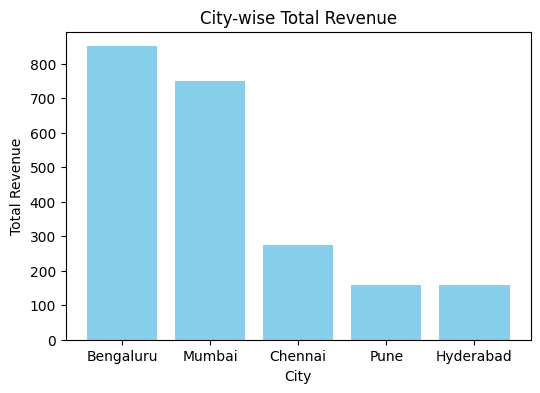

In [33]:
import matplotlib.pyplot as plt
city_rev_df = spark.sql("""
    SELECT city, SUM(total_amount) AS total_revenue
    FROM gold_view
    GROUP BY city
    ORDER BY total_revenue DESC
""").toPandas()
plt.figure(figsize=(6,4))
plt.bar(city_rev_df['city'], city_rev_df['total_revenue'], color='skyblue')
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.title("City-wise Total Revenue")
plt.show()


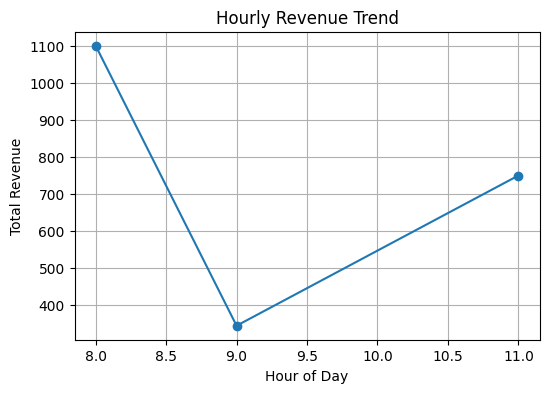

In [32]:
#line chart
hourly_rev_df = spark.sql("""
    SELECT HOUR(ts) AS hour, SUM(total_amount) AS total_revenue
    FROM gold_view
    GROUP BY HOUR(ts)
    ORDER BY hour
""").toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(hourly_rev_df['hour'], hourly_rev_df['total_revenue'], marker='o')
plt.xlabel("Hour of Day")
plt.ylabel("Total Revenue")
plt.title("Hourly Revenue Trend")
plt.grid(True)
plt.show()


#12) Managed vs Unmanaged Cleanup



In [ ]:
#DROP TABLE the managed and unmanaged tables;
'''verify:
Data for managed is removed with the table (when stored in the
warehouse).
Data for unmanaged stays at DRIVERS_PATH after drop.'''
# Drop managed and unmanaged tables
spark.sql("DROP TABLE IF EXISTS trips_managed")
spark.sql("DROP TABLE IF EXISTS drivers_ext")

import os

print(" Managed table")
managed_location = f"/tmp/spark-warehouse/trips_managed"
if os.path.exists(managed_location):
    print("Still exists:", managed_location)
else:
    print(" Removed:", managed_location)

print(" Unmanaged table")
if os.path.exists(DRIVERS_PATH):
    print("Still exists:", DRIVERS_PATH)
    print("Files:", os.listdir(DRIVERS_PATH))
else:
    print("Removed:", DRIVERS_PATH)



#Constraint/Quality Check (Optional)


In [34]:
#Add a check to reject rows where tip < 0 (enforce during write or simulate with a filter before save).
#Demonstrate an attempt to write bad data and show how you prevented it.
import datetime
bad_data = [    (2001, "R020", "D010", "Bengaluru", 10.0, 250.0, -5.0, datetime.datetime(2025, 8, 8, 15, 0, 0))]
bad_df = spark.createDataFrame(bad_data, schema=trip_schema)
bad_df.show()


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   2001|    R020|     D010|Bengaluru|       10.0|250.0|-5.0|2025-08-08 15:00:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [35]:

valid_df = bad_df.filter(F.col("tip") >= 0)
if valid_df.count() == bad_df.count():

    valid_df.write.format("delta").mode("append").saveAsTable("trips_managed")
    print("Data written successfully.")
else:
    print("Bad data detected!")


Bad data detected!


#14) Convert Parquet → Delta (Optional)

In [37]:
#Save a small subset of trips as Parquet in a new folder and CONVERT TO DELTA.
PARQUET_PATH = f"{BASE}/trips_parquet"
spark.read.table("trips_managed").write.format("parquet").mode("overwrite").save(PARQUET_PATH)

print( PARQUET_PATH)




/tmp/delta/ride_hailing/trips_parquet


In [38]:

spark.sql(f"CONVERT TO DELTA parquet.`{PARQUET_PATH}`")




DataFrame[]

In [39]:
#Show it can now accept MERGE and time travel.
from delta.tables import DeltaTable
import datetime
delta_parquet = DeltaTable.forPath(spark, PARQUET_PATH)
merge_updates = [
    (1001, "R001", "D010", "Bengaluru", 12.4, 350.0, 25.0, datetime.datetime(2025, 8, 8, 8, 5, 0)), # updated fare/tip
    (3001, "R030", "D013", "Chennai",   9.0,  220.0, 12.0, datetime.datetime(2025, 8, 8, 16, 0, 0))  # new trip
]
merge_df = spark.createDataFrame(merge_updates, schema=trip_schema)
delta_parquet.alias("t") \
    .merge(merge_df.alias("s"), "t.trip_id = s.trip_id") \
    .whenMatchedUpdateAll() \
    .whenNotMatchedInsertAll() \
    .execute()
spark.read.format("delta").load(PARQUET_PATH).show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|350.0|25.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|30.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
|   1008|    R007|     D011|   Mumbai|        8.0|200.0|15.0|2025-08-08 11:15:00|
|   3001|    R030|     D013|  Chennai|        9.0|220.0|12.0|2025-08-08 16:00:00|
|   1008|    R007|     D011|   Mumbai|        8.0|200.0|15.0|2025-08-08 11:15:00|
|   1009|    R00

In [40]:

spark.sql(f"DESCRIBE HISTORY delta.`{PARQUET_PATH}`").show(truncate=False)
spark.read.format("delta").option("versionAsOf", 0).load(PARQUET_PATH).show()
spark.read.format("delta").load(PARQUET_PATH).show()


+-------+-----------------------+------+--------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|versio

# Bonus KPI Dashboard (Notebook Display)

Total Revenue: 2195.0


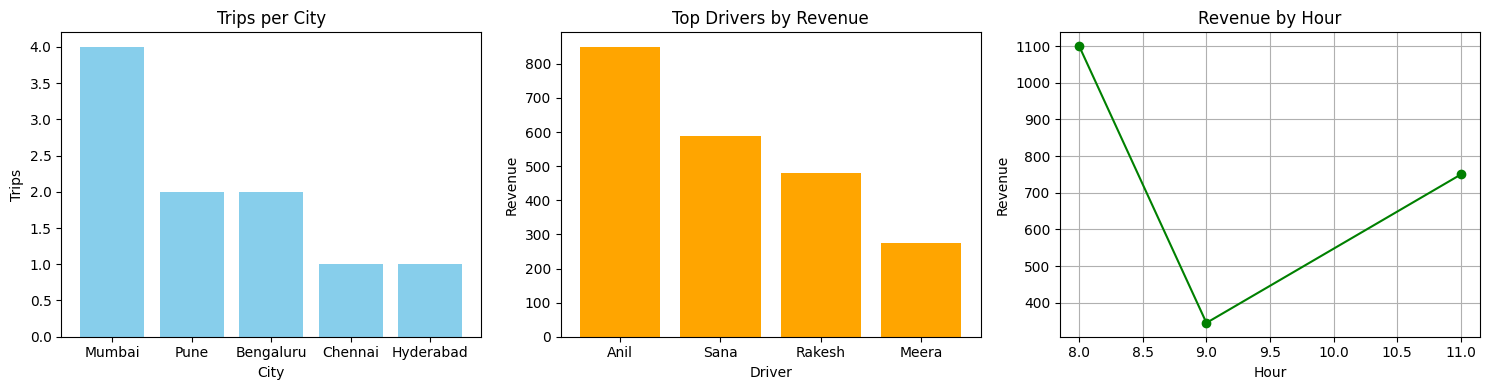

In [43]:
'''Build a quick section showing:
Total revenue
Trips per city (bar)
Top drivers by revenue (bar)
Revenue by hour (line)
(In Databricks, use display() chart UI; in Colab, use matplotlib.)'''
import matplotlib.pyplot as plt

# Total Revenue
total_revenue = spark.sql("SELECT SUM(total_amount) AS total_revenue FROM gold_view").collect()[0][0]
print(f"Total Revenue: {total_revenue}")

# Trips per City
trips_per_city = spark.sql("""
    SELECT city, COUNT(*) AS total_trips
    FROM gold_view
    GROUP BY city
    ORDER BY total_trips DESC
""").toPandas()

# Top Drivers by Revenue
top_drivers = spark.sql("""
    SELECT driver_name, SUM(total_amount) AS revenue
    FROM gold_view
    GROUP BY driver_name
    ORDER BY revenue DESC
    LIMIT 5
""").toPandas()

# Revenue by Hour
rev_by_hour = spark.sql("""
    SELECT HOUR(ts) AS hour, SUM(total_amount) AS revenue
    FROM gold_view
    GROUP BY HOUR(ts)
    ORDER BY hour
""").toPandas()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15,4))

# Bar: Trips per city
axs[0].bar(trips_per_city['city'], trips_per_city['total_trips'], color='skyblue')
axs[0].set_title("Trips per City")
axs[0].set_xlabel("City")
axs[0].set_ylabel("Trips")

# Bar: Top drivers by revenue
axs[1].bar(top_drivers['driver_name'], top_drivers['revenue'], color='orange')
axs[1].set_title("Top Drivers by Revenue")
axs[1].set_xlabel("Driver")
axs[1].set_ylabel("Revenue")

# Line: Revenue by hour
axs[2].plot(rev_by_hour['hour'], rev_by_hour['revenue'], marker='o', color='green')
axs[2].set_title("Revenue by Hour")
axs[2].set_xlabel("Hour")
axs[2].set_ylabel("Revenue")
axs[2].grid(True)
plt.tight_layout()
plt.show()
